In [105]:
import argparse
import numpy as np
import os
import tabulate
import torch
import torch.nn.functional as F
import torch.nn

import data
import models
import curves
import utils

import pickle
from pylab import rcParams

In [106]:
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

from scipy.stats import norm

import utils
import time
from torch import nn
import seaborn as sns
from sklearn.manifold import TSNE

In [107]:
def test(model):
    train_res = utils.test(loaders['train'], model, criterion, regularizer)
    test_res = utils.test(loaders['test'], model, criterion, regularizer) 
    print(train_res)
    print(test_res)

In [108]:
def distance(model1, model2):
    par1 = np.concatenate([p.data.cpu().numpy().ravel() for p in model1.parameters()])
    par2 = np.concatenate([p.data.cpu().numpy().ravel() for p in model2.parameters()])
    u = par2 - par1
    dx = np.linalg.norm(u)
    return dx

In [109]:
def get_vector(model1):
    par1 = np.concatenate([p.data.cpu().numpy().ravel() for p in model1.parameters()])
    return par1

In [110]:
from pylab import rcParams
rcParams['figure.figsize'] = 12, 10
rcParams['figure.dpi'] = 100

In [111]:
def get_model(W, B, architecture):
    model_sampled = architecture.base(num_classes=10, **architecture.kwargs)
    model_samples = np.array(W) #.cpu().data.numpy()
    SIZE = model_sampled.middle_dim

    offset = 0
    for parameter in list(model_sampled.parameters())[:-1]:
        size = int(np.prod(parameter.size())/SIZE)
        value = model_samples[:, offset:offset+size]
        if size==10 or size==1:
             value = value.T
#         print(value.shape)
        value = value.reshape(parameter.size())
#         print(value.shape)
        parameter.data.copy_(torch.from_numpy(value))
        offset += size

    list(model_sampled.parameters())[-1].data.copy_(B.mean(0)) #torch.from_numpy(
    
    return model_sampled

def test(model):
    criterion = F.cross_entropy
    regularizer = None 
    train_res = utils.test(loaders['train'], model, criterion, regularizer)
    test_res = utils.test(loaders['test'], model, criterion, regularizer) 
    print(train_res)
    print(test_res)

# def samples(model):
#     p1 = list(model.parameters())[0].data.cpu().numpy()
#     p2 = list(model.parameters())[1].data.cpu().numpy()
#     p3 = list(model.parameters())[2].transpose(0,1).data.cpu().numpy()
#     samples = np.hstack([p1, p2[:, None], p3])
    
#     return samples

In [8]:
def plot_singl_values(model1, model2, ind, plot=False):
    W1 = list(model1.parameters())[ind].data.numpy()
    W2 = list(model2.parameters())[ind].data.numpy()

    _, s1, _ = np.linalg.svd(W1)
    _, s2, _ = np.linalg.svd(W2)

    if plot:
        fig, axes = plt.subplots(1, 2,)
        axes[0, 0].set_title('W1 model1')
        axes[0, 0].plot(s1)
        axes[0, 1].set_title('W2 model1')
        axes[0, 1].plot(s2)
        plt.show()
    
    return s1, s2

In [9]:
def look_at_models(model1, model2, model3, model4, architecture, index):
    
    if index == 0:
        print("distance between train models", distance(model1, model2))
        print("distance between initial models", distance(model3, model4))
        print("how far model1 go", distance(model1, model3))
        print("how far model2 go", distance(model2, model4))
    
    rcParams['figure.figsize'] = 12, 10
    rcParams['figure.dpi'] = 100
    
    print('initial singular values')
    si1, si2 = plot_singl_values(model3, model4, index, plot=False)
    
    print('train singular values')
    s1, s2 = plot_singl_values(model1, model2, index, plot=False)
    
    print('initial singular values distribution')
    plt.hist(si1, bins = 50, density=True, alpha = 0.5);
    plt.hist(si2, bins = 50, density=True, alpha = 0.5);
    plt.show()
    
    print('train singular values distribution')
    plt.hist(s1, bins = 50, density=True, alpha = 0.5)
    plt.hist(s2, bins = 50, density=True, alpha = 0.5)
    plt.show()
    
    print('train and initial singular values distribution')
    plt.hist(si1, bins = 50, density=True, alpha = 0.5)
    plt.hist(s1, bins = 50, density=True, alpha = 0.5)
    plt.show()
    
    
    if index == 0:
        print('train models eigenvector heatmap')
        heat_image(model1)
        heat_image(model2)


        print('scalar product between train models')
        w1 = get_vector(model1)
        w2 = get_vector(model2)
        print('norms w1, w2', np.linalg.norm(w1), np.linalg.norm(w2))
        print('cos', (w1*w2).sum()/(np.linalg.norm(w1)*np.linalg.norm(w2)))
    
def samples(model):
    p1 = list(model.parameters())[0].data.cpu().numpy()
    p2 = list(model.parameters())[1].data.cpu().numpy()
    p3 = list(model.parameters())[2].transpose(0,1).data.cpu().numpy()
    samples = np.hstack([p1, p2[:, None], p3])
    
    return samples
    

In [10]:
def get_ev(model, index=0):
    W11 = list(model.parameters())[index].data.numpy()
    A = W11.T @ W11
    l, v = np.linalg.eig(A)
    v = np.real(v)
    l = np.real(l)
    return v, l
    

def heat_image(model):
    
    ev, e = get_ev(model)
    N = 5
    fig, ax = plt.subplots(1, N)
    
#     W11 = list(model.parameters())[0].data.numpy()
#     _, _, vh = np.linalg.svd(W11)
#     ev = vh.T @ ev
#     ev = ev>ev.mean()
    
    
    rcParams['figure.figsize'] = 15, 15
    rcParams['figure.dpi'] = 100
    
    for ind, (im, l) in enumerate(zip(ev.T[:N], e[:N])):
        im = np.abs(im.reshape((28, 28)))

        ax[ind].imshow(im)
        ax[ind].set_title(l)
        
#     plt.colorbar()
#     plt.axis('off')
    plt.show()

In [11]:
architecture = getattr(models, "LinearOneLayer") #LinearOneLayer LogRegression
model = architecture.base(num_classes=10, **architecture.kwargs)

loaders, num_classes = data.loaders(
    "MNIST",
    "data",
    128,
    1,
    "VGG",
    True)

criterion = F.cross_entropy
regularizer = None 



model1 = architecture.base(num_classes=10, **architecture.kwargs)
model2 = architecture.base(num_classes=10, **architecture.kwargs)
model3 = architecture.base(num_classes=10, **architecture.kwargs)
model4 = architecture.base(num_classes=10, **architecture.kwargs)

You are going to run models on the test set. Are you sure?


In [24]:
model1.load_state_dict(torch.load('curves_mnist/LinearOneLayer/Adam/curve5/checkpoint-30.pt')['model_state'])
model2.load_state_dict(torch.load('curves_mnist/LinearOneLayer/Adam/curve6/checkpoint-30.pt')['model_state'])

model3.load_state_dict(torch.load('curves_mnist/LinearOneLayer/Adam/curve5/checkpoint-0.pt')['model_state'])
model4.load_state_dict(torch.load('curves_mnist/LinearOneLayer/Adam/curve6/checkpoint-0.pt')['model_state'])

distance between train models 38.311127
distance between initial models 36.605488
how far model1 go 37.460575
how far model2 go 37.415936
initial singular values
train singular values
initial singular values distribution


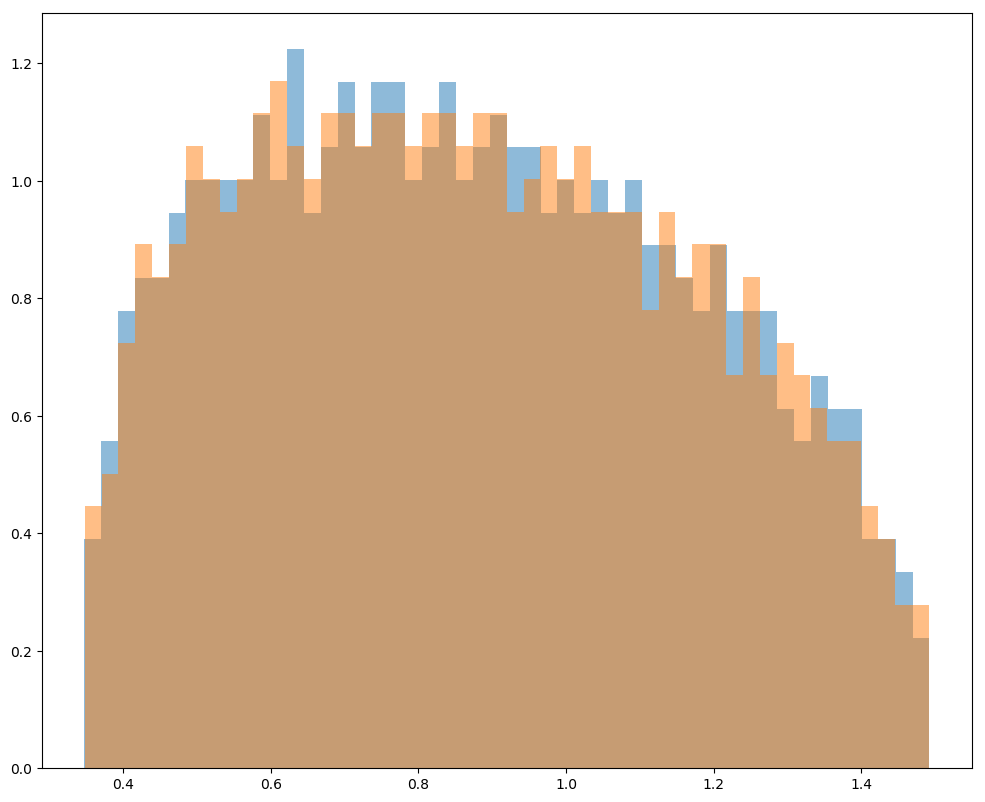

train singular values distribution


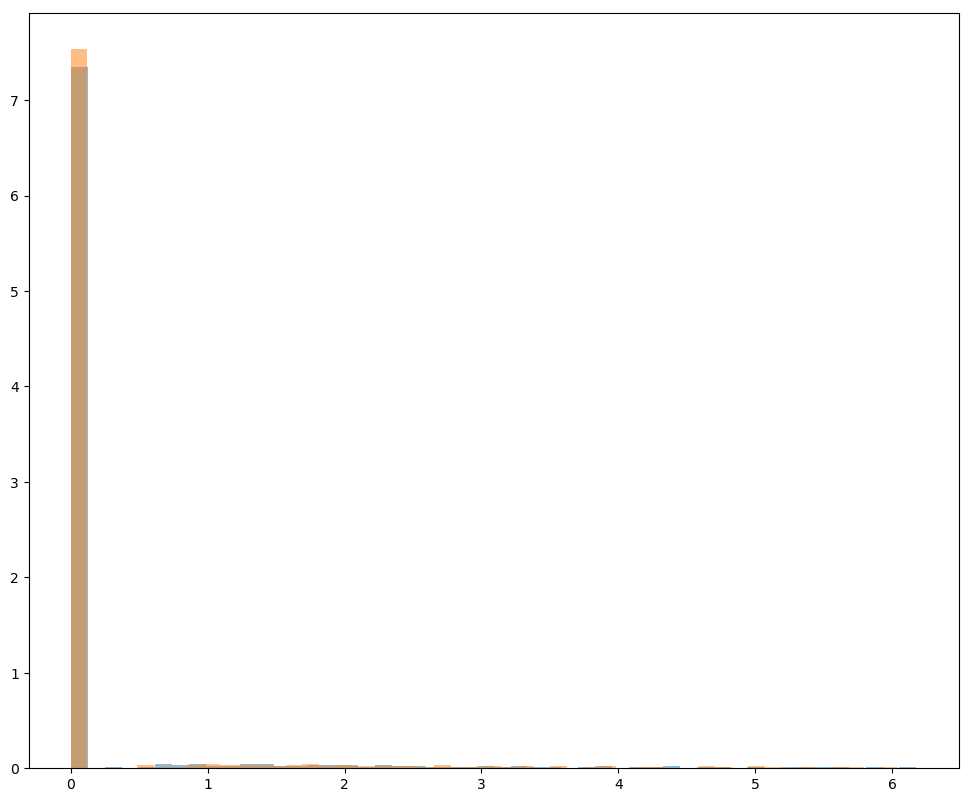

train and initial singular values distribution


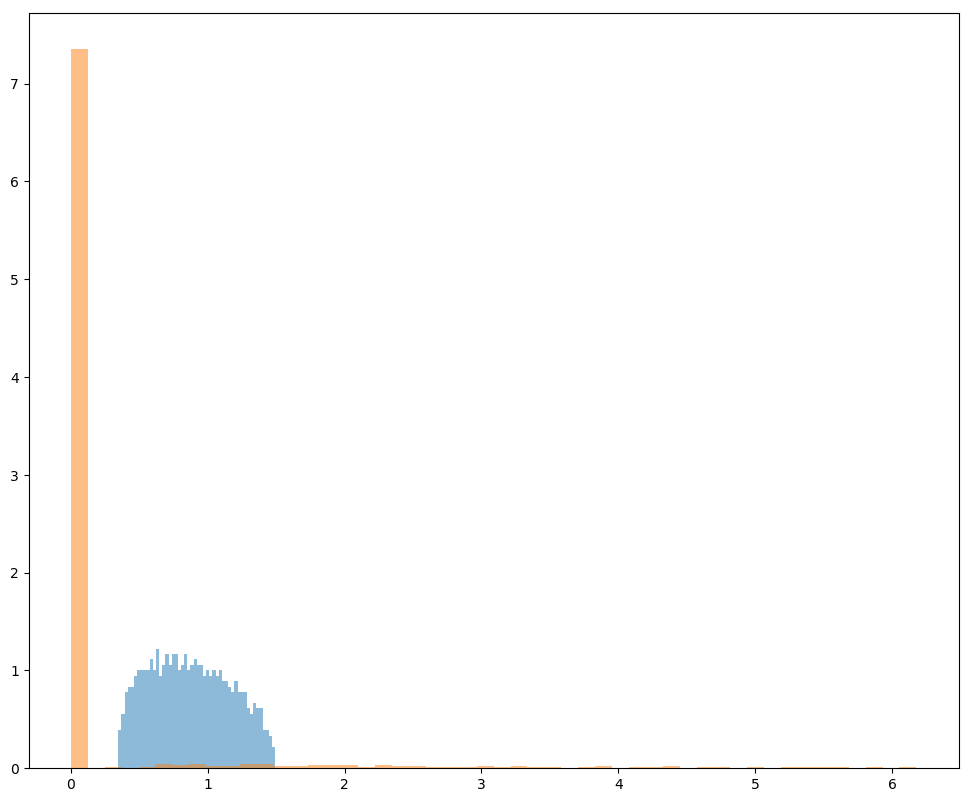

train models eigenvector heatmap


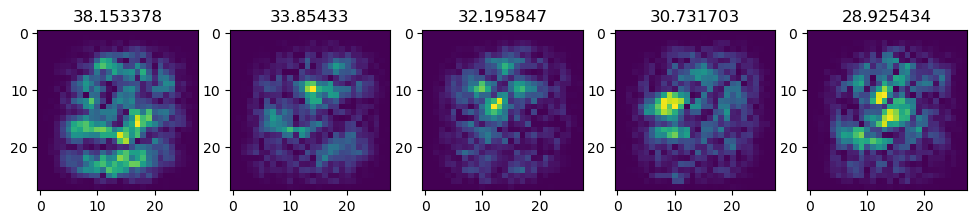

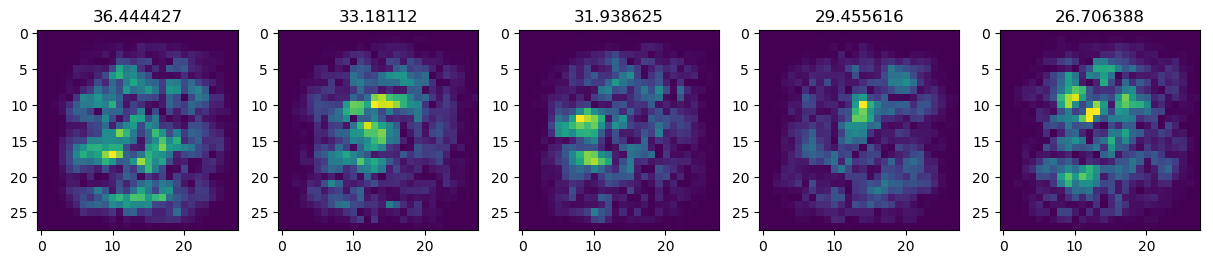

scalar product between train models
norms w1, w2 27.177952 27.135677
cos 0.004911071


In [25]:
look_at_models(model1, model2, model3, model4, architecture, 0)

# What if we zero all weights near zero

In [26]:
test(model1)
test(model2)

{'nll': 0.013226513437430063, 'loss': 0.013226513437430063, 'accuracy': 99.80666666666667}
{'nll': 0.059089827513694765, 'loss': 0.059089827513694765, 'accuracy': 98.14}
{'nll': 0.01239673071304957, 'loss': 0.01239673071304957, 'accuracy': 99.82833333333333}
{'nll': 0.05553358361721039, 'loss': 0.05553358361721039, 'accuracy': 98.37}


In [27]:
W1 = list(model1.parameters())[0].cpu().data.numpy()
W1.shape
_, s1, vh = np.linalg.svd(W1)
vh.shape
A = W1.T @ W1
l, v = np.linalg.eig(A)
v = np.real(v)

In [28]:
F.softmax(model1(torch.tensor(vh[:1])))

/home/anokhin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """Entry point for launching an IPython kernel.


tensor([[0.0227, 0.0075, 0.5891, 0.0165, 0.0079, 0.1273, 0.2112, 0.0023, 0.0132,
         0.0023]], grad_fn=<SoftmaxBackward>)

In [29]:
def samples(model):
    p1 = list(model.parameters())[0].data.numpy()
    p2 = list(model.parameters())[1].data.numpy()
    p3 = list(model.parameters())[2].transpose(0,1).data.numpy()
    samples = np.hstack([p1, p2[:, None], p3])
    
    return samples

In [30]:
def get_zero_W(model, beg_index=0):
    W = samples(model)
    W_new = np.zeros(W.shape)
    We = W[((np.abs(W)>0.1).sum(-1)>3)]
    W_new[beg_index:beg_index+We.shape[0]] = We
    return W_new, beg_index+We.shape[0]
    

In [31]:
B = []
B.append(list(model1.parameters())[-1].data.numpy())
B.append(list(model2.parameters())[-1].data.numpy())
B = np.array(B)

In [117]:
def get_model(W, B):
    model_sampled = architecture.base(num_classes=10, **architecture.kwargs)
    model_samples = W #.cpu().data.numpy()
    SIZE = 2000

    offset = 0
    for parameter in list(model_sampled.parameters())[:-1]:
        size = int(np.prod(parameter.size())/SIZE)
        value = model_samples[:, offset:offset+size]
        if size==10 or size==1:
             value = value.T
#         print(value.shape)
        value = value.reshape(parameter.size())
#         print(value.shape)
        parameter.data.copy_(torch.from_numpy(value))
        offset += size

    list(model_sampled.parameters())[-1].data.copy_(torch.from_numpy(B.mean(0)))
    
    return model_sampled

In [33]:
W1, ind1 = get_zero_W(model1)
model_sampled1 = get_model(W1, B)
test(model_sampled1)

{'nll': 0.013214103844265144, 'loss': 0.013214103844265144, 'accuracy': 99.81166666666667}
{'nll': 0.059122777366638186, 'loss': 0.059122777366638186, 'accuracy': 98.17}


In [34]:
W2, ind2 = get_zero_W(model2)
model_sampled2 = get_model(W2, B)
test(model_sampled2)

{'nll': 0.012444851277768612, 'loss': 0.012444851277768612, 'accuracy': 99.83333333333333}
{'nll': 0.05570257394313812, 'loss': 0.05570257394313812, 'accuracy': 98.37}


In [35]:
# W2.shape

In [36]:
W1, ind1 = get_zero_W(model1, beg_index = 0)
W2, ind2 = get_zero_W(model2, beg_index = ind1)
W3 = W1+W2
model_sampled3 = get_model(W3, B)
test(model_sampled3)

{'nll': 0.008663839403788249, 'loss': 0.008663839403788249, 'accuracy': 99.82166666666667}
{'nll': 0.07702614526748658, 'loss': 0.07702614526748658, 'accuracy': 98.43}


In [112]:
W = np.zeros(W1.shape)
ind = 0
B = []
for i in range(1, 20+1):
    model1.load_state_dict(torch.load('curves_mnist/LinearOneLayer/Adam/curve'+str(i)+'/checkpoint-30.pt')['model_state'])
    B.append(list(model1.parameters())[-1].data.numpy())
    W1, ind = get_zero_W(model1, beg_index = ind)
    W = W + W1
    print(ind)

B = np.array(B)

70
136
207
279
352
424
497
569
638
707
778
849
920
986
1058
1127
1196
1260
1331
1404


In [115]:
# W[1404-1]

In [118]:
model_sampledF = get_model(W, B)
test(model_sampledF)

{'nll': 0.07147026211420696, 'loss': 0.07147026211420696, 'accuracy': 99.80666666666667}
{'nll': 0.662451837348938, 'loss': 0.662451837348938, 'accuracy': 98.46}


# Distributions

In [38]:
# W[ind-1]

distribution in strong pixel, train and initial model1 


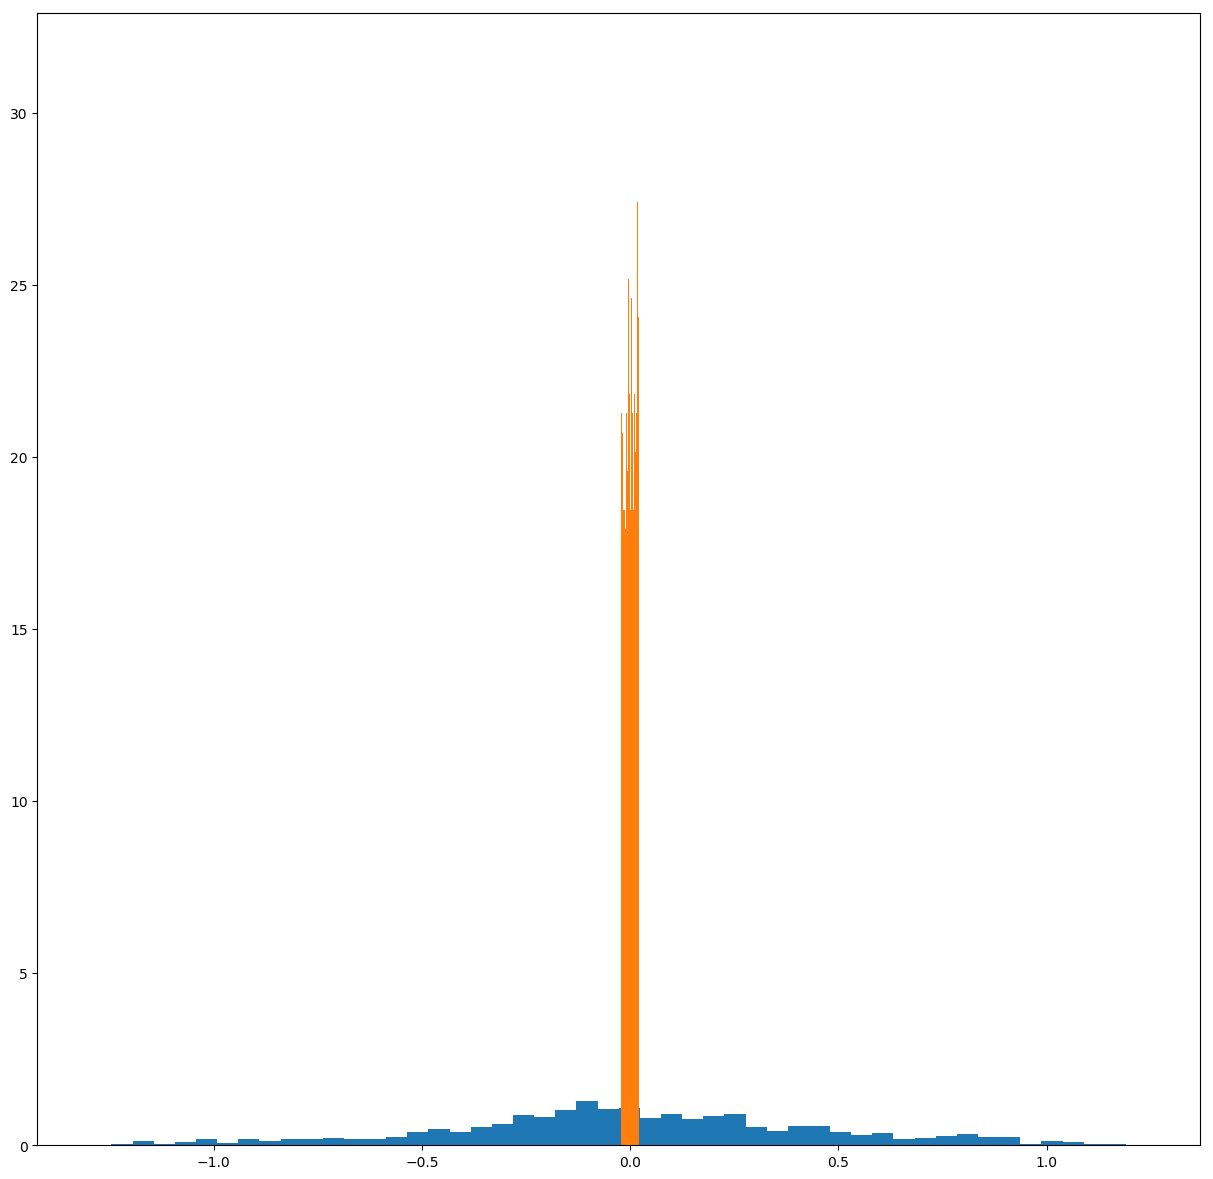

distribution in week pixel, train and initial model1 


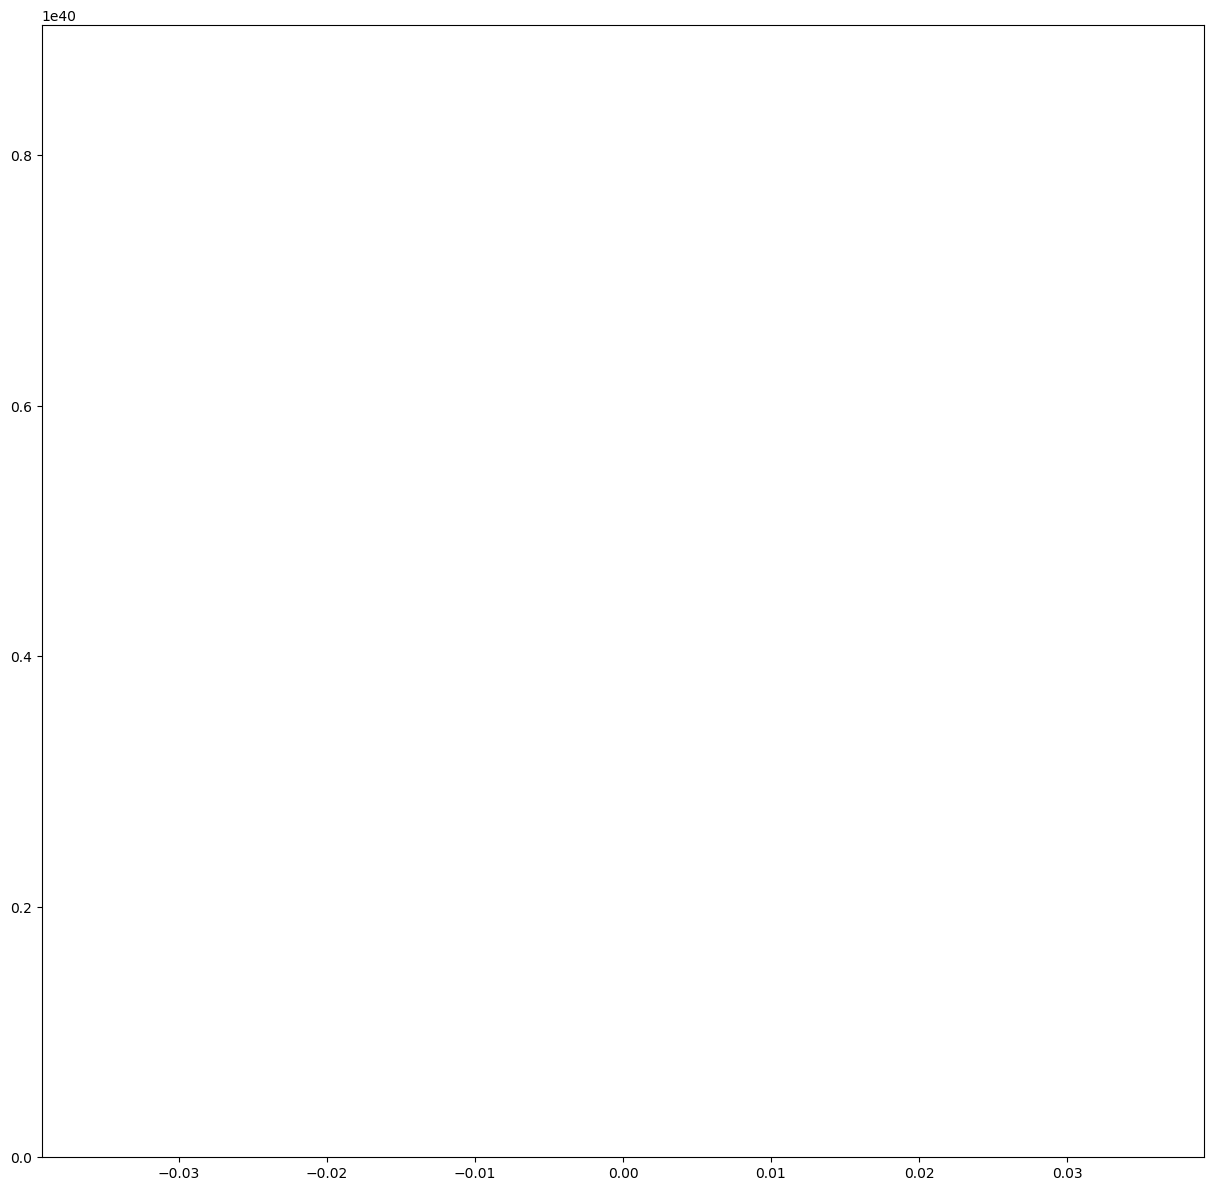

strong


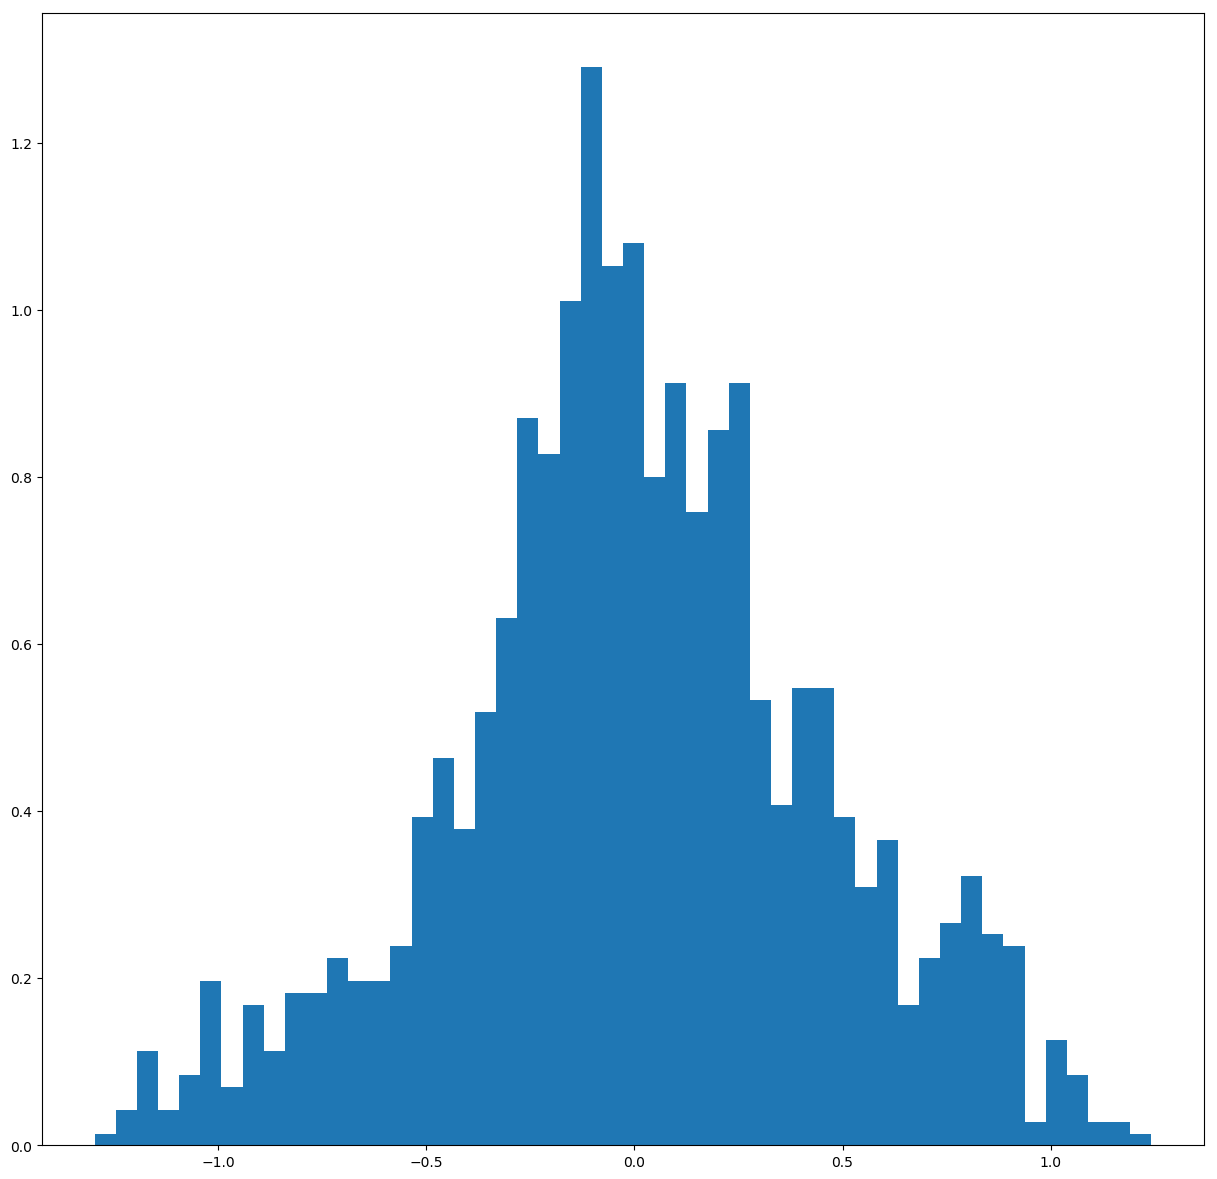

week


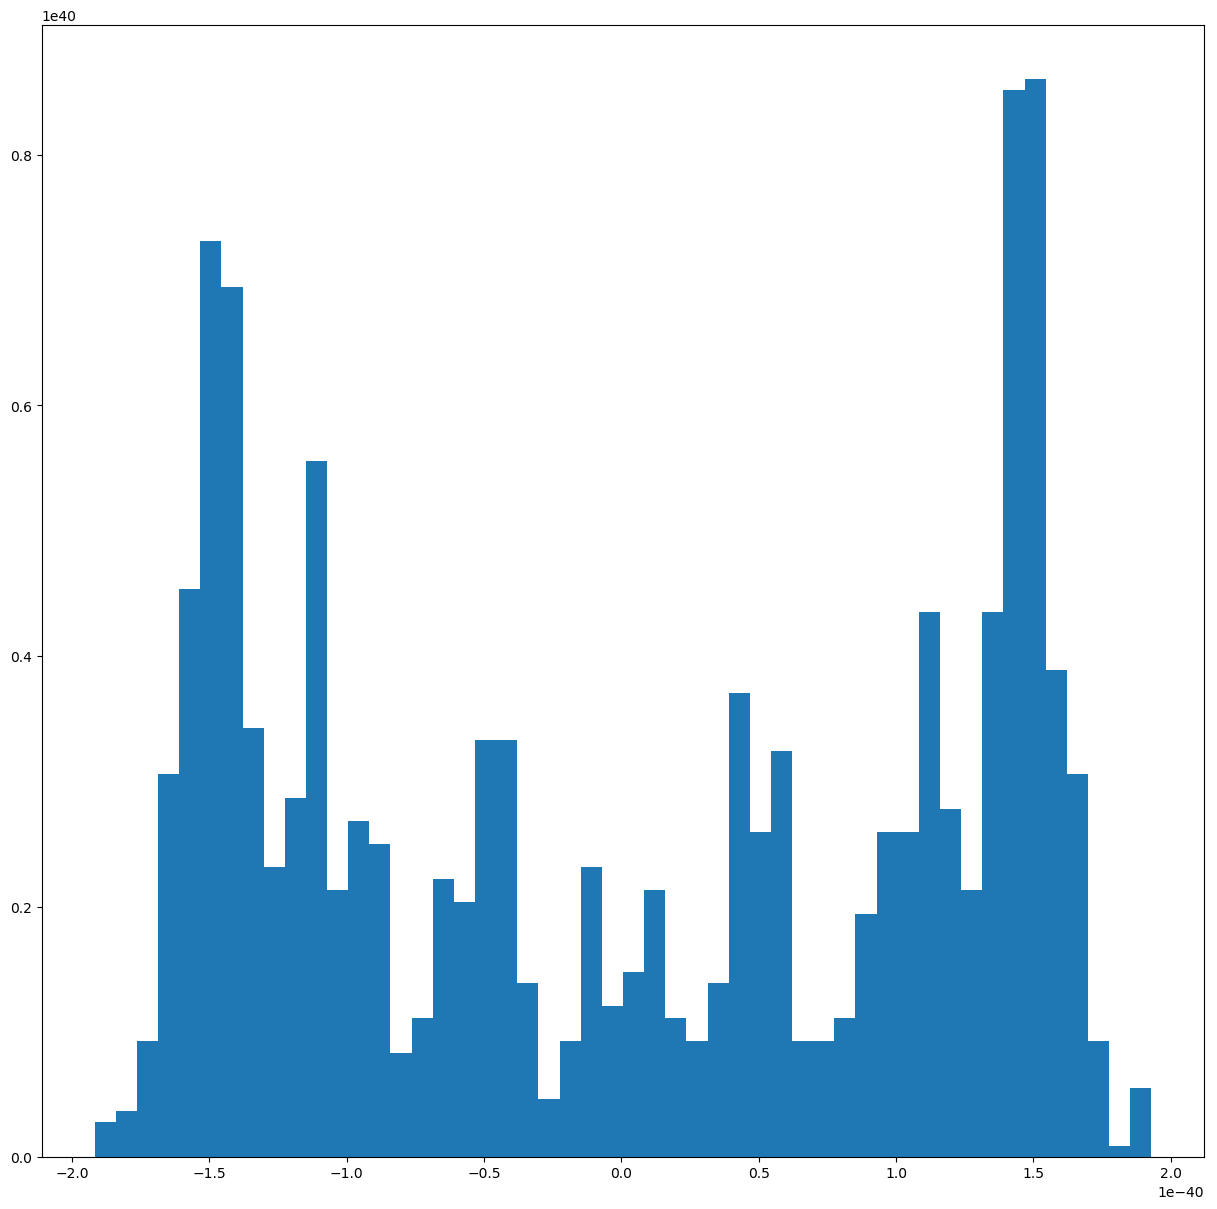

In [39]:
S1 = W[:ind]
S_initial1 = samples(model3)

week, strong = 1, -5

print('distribution in strong pixel, train and initial model1 ')
plt.hist(S1[:, strong], bins=50, density=True)
plt.hist(S_initial1[:, strong], bins=50, density=True)
plt.show()


print('distribution in week pixel, train and initial model1 ')
plt.hist(S1[:, week], bins=50, density=True)
plt.hist(S_initial1[:, week], bins=50, density=True)
plt.show()

rcParams['figure.dpi'] = 100

print('strong')
plt.hist(S1[:, strong], bins=50, density=True)
plt.show()

print('week')
plt.hist(S1[:, week], bins=50, density=True)
plt.show()


## Arc middle point model between zero weights models

In [40]:
def test_Arc_model(model1, model2):

    B = []
    B.append(list(model1.parameters())[-1].data.numpy())
    B.append(list(model2.parameters())[-1].data.numpy())
    B = np.array(B)

    W1, ind1 = get_zero_W(model1)
    model_sampled1 = get_model(W1, B)
    W1 = W1[:ind1]

    W2, ind2 = get_zero_W(model2)
    model_sampled2 = get_model(W2, B)
    W2 = W2[:ind2]
    
    S = (W1.sum(0, keepdims = True)+W2.sum(0, keepdims = True))/(W1.shape[0]+W2.shape[0])
#     print('S', S)
    
    S = np.repeat(S.mean(0, keepdims = True), repeats=model1.middle_dim, axis=0)
    print(S.shape)
    mu = get_model(S, B)

    print('computing Arc model...')
    model_Arc = architecture.base(num_classes=10, **architecture.kwargs)
    for i, (parameter, p1, p2, m) in enumerate(zip(model_Arc.parameters(), model_sampled1.parameters(), model_sampled2.parameters(), mu.parameters())):    
        parameter.data.copy_(m + (1/np.sqrt(2))*(p1-m)+(1/np.sqrt(2))*(p2-m))
    print('test Arc')
    test(model_Arc)

In [41]:
 test_Arc_model(model1, model2)

(2000, 795)
computing Arc model...
test Arc
{'nll': 32.805008204142254, 'loss': 32.805008204142254, 'accuracy': 13.438333333333333}
{'nll': 33.25308031616211, 'loss': 33.25308031616211, 'accuracy': 13.05}


## What if we add noisy neurons

In [72]:
W1, ind1 = get_zero_W(model1)

In [73]:
def noisify_good_weights(model):
    
    W1, N = get_zero_W(model1)
    We = W1[:N]
    
    for i in range(0, 2000-N, N):  
        rk = np.random.randn(N, 795)/10+1
        W1[i:i+N] = We*rk
    
    i+=N
    rk = np.random.randn(N, 795)/10+1
    W1[i:] = We[:2000-i]*rk[:2000-i]
    return W1

    

In [74]:
W1N = noisify_good_weights(model1)
B = []
B.append(list(model1.parameters())[-1].data.numpy())
B = np.array(B)

In [75]:
model_sampled1N = get_model(W1N, B)
test(model_sampled1N)

{'nll': 0.16954831035137177, 'loss': 0.16954831035137177, 'accuracy': 99.525}
{'nll': 1.370445238494873, 'loss': 1.370445238494873, 'accuracy': 97.83}


### Retraining 

In [71]:
def train(model):
    
    criterion = F.cross_entropy
    regularizer = None 
    optimizer = torch.optim.SGD(
        filter(lambda param: param.requires_grad, model.parameters()),
        lr=0.0001,
        momentum=0.9,
        weight_decay=1e-4
    )
    model.cuda();

    columns = ['ep', 'tr_loss', 'tr_acc', 'te_nll', 'te_acc', 'time']
    for epoch in range(0, 10 + 1):
        time_ep = time.time()

        train_res = utils.train(loaders['train'], model, optimizer, criterion, regularizer, cuda=True)
        test_res = utils.test(loaders['test'], model, criterion, regularizer, cuda=True)

        time_ep = time.time() - time_ep
        values = [epoch, train_res['loss'], train_res['accuracy'], test_res['nll'],
                  test_res['accuracy'], time_ep]

        table = tabulate.tabulate([values], columns, tablefmt='simple', floatfmt='9.4f')
        print(table)

In [76]:
train(model_sampled1N)

  ep    tr_loss     tr_acc     te_nll     te_acc       time
----  ---------  ---------  ---------  ---------  ---------
   0     0.1635    99.5500     1.3394    97.8800     4.0025
  ep    tr_loss     tr_acc     te_nll     te_acc       time
----  ---------  ---------  ---------  ---------  ---------
   1     0.1530    99.6000     1.3168    97.9600     4.0210
  ep    tr_loss     tr_acc     te_nll     te_acc       time
----  ---------  ---------  ---------  ---------  ---------
   2     0.1455    99.6200     1.2981    97.9800     3.9694
  ep    tr_loss     tr_acc     te_nll     te_acc       time
----  ---------  ---------  ---------  ---------  ---------
   3     0.1396    99.6400     1.2823    97.9800     4.0511
  ep    tr_loss     tr_acc     te_nll     te_acc       time
----  ---------  ---------  ---------  ---------  ---------
   4     0.1348    99.6617     1.2692    98.0000     3.9860
  ep    tr_loss     tr_acc     te_nll     te_acc       time
----  ---------  ---------  ---------  -

In [77]:
model_sampled1N.cpu();

distribution in strong pixel, train and initial model1 


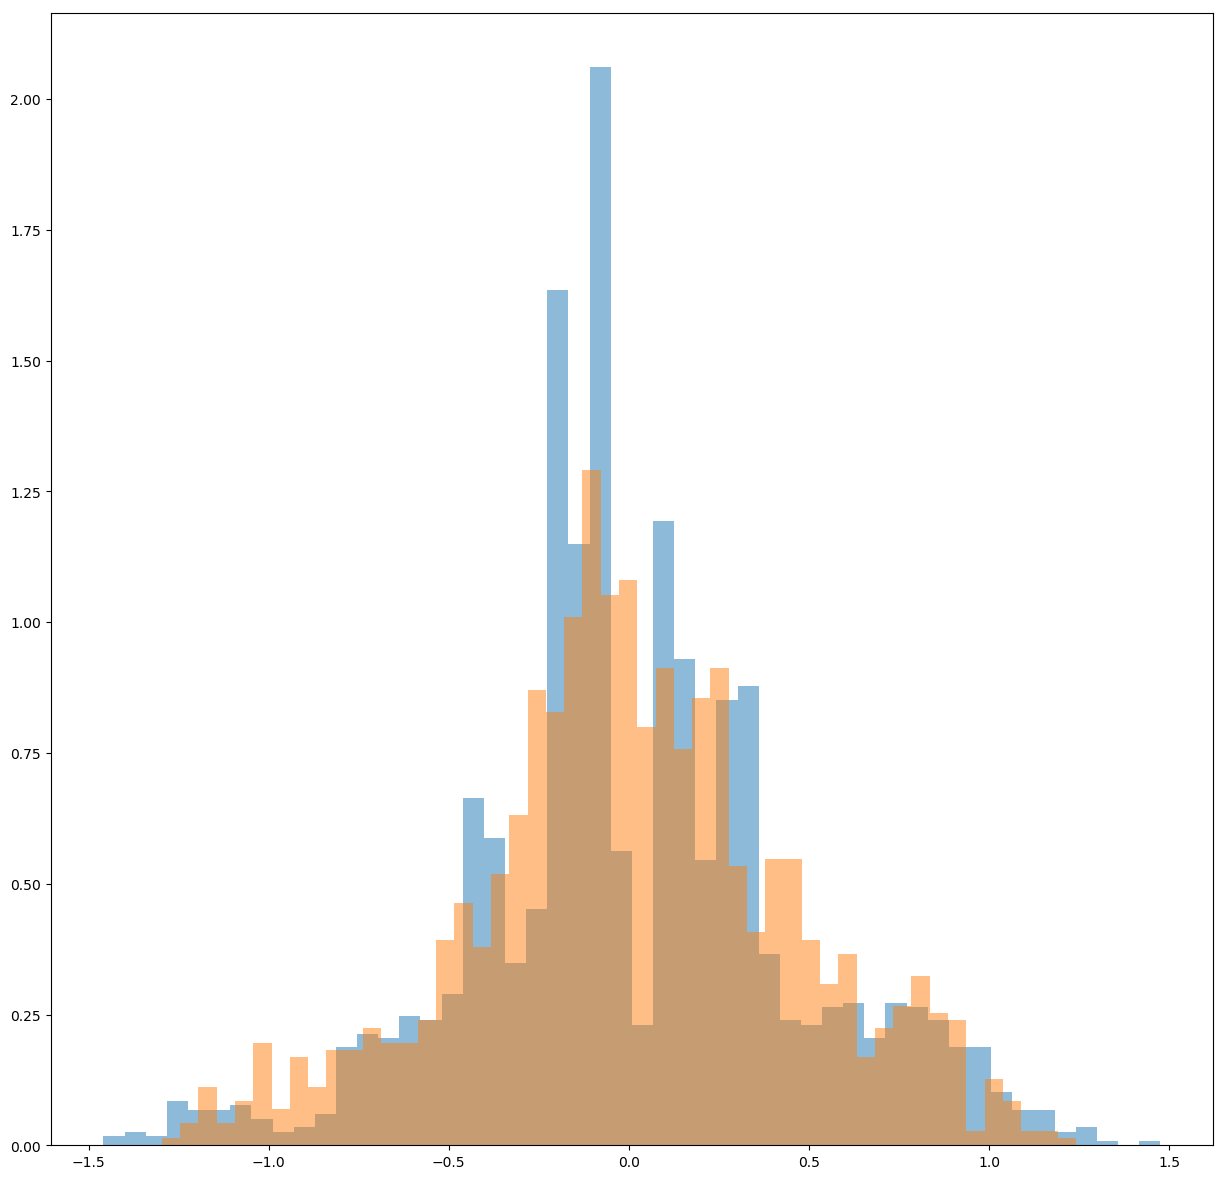

distribution in week pixel, train and initial model1 


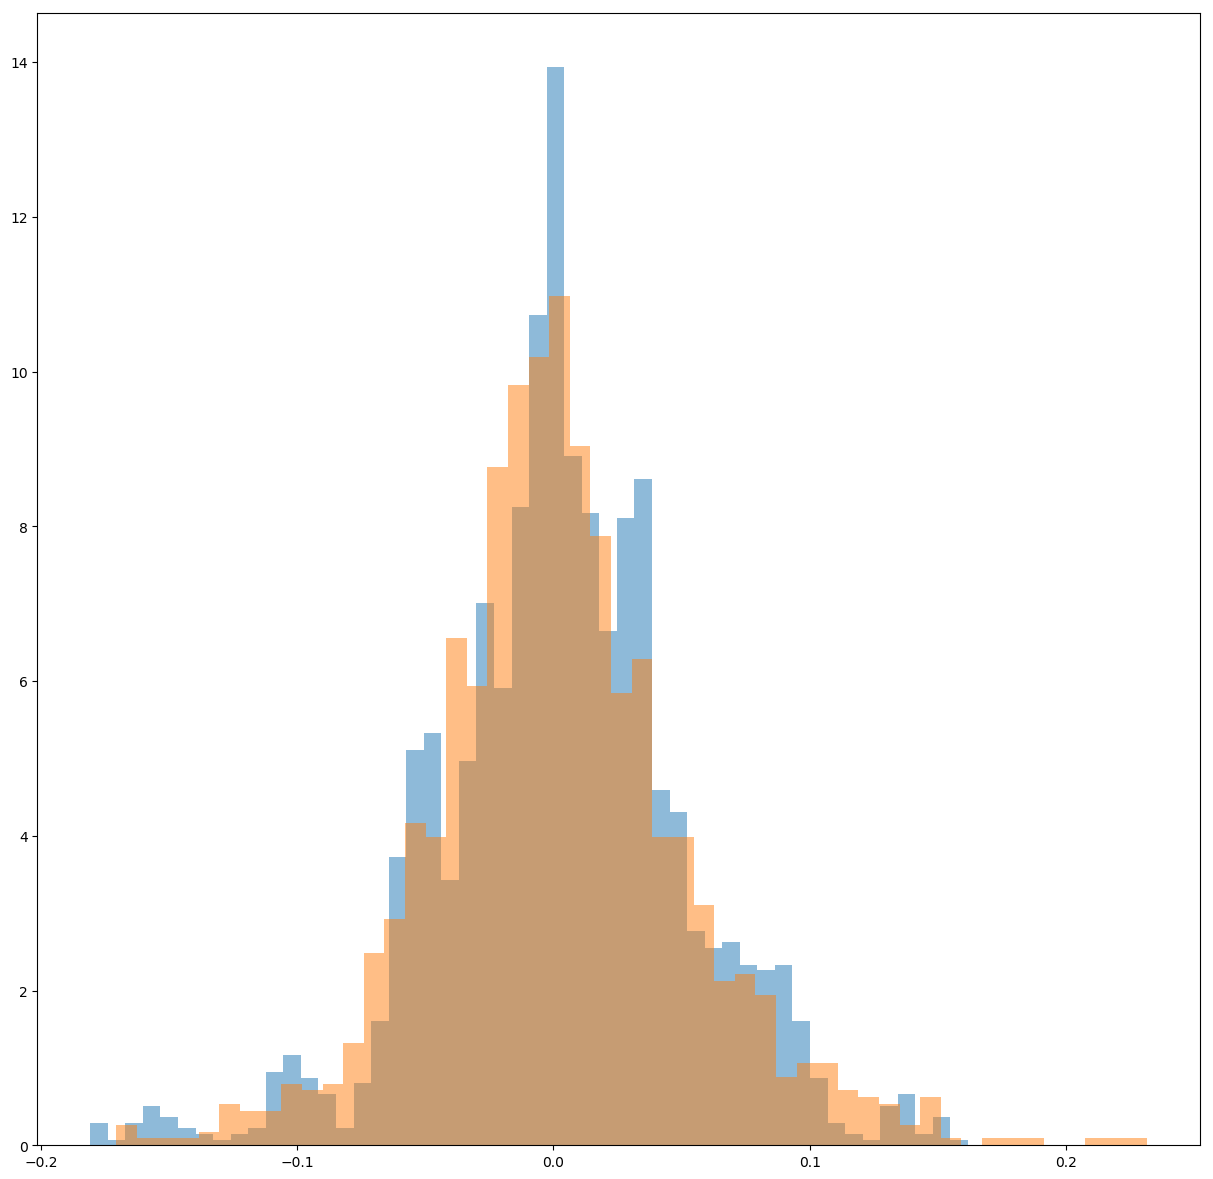

strong


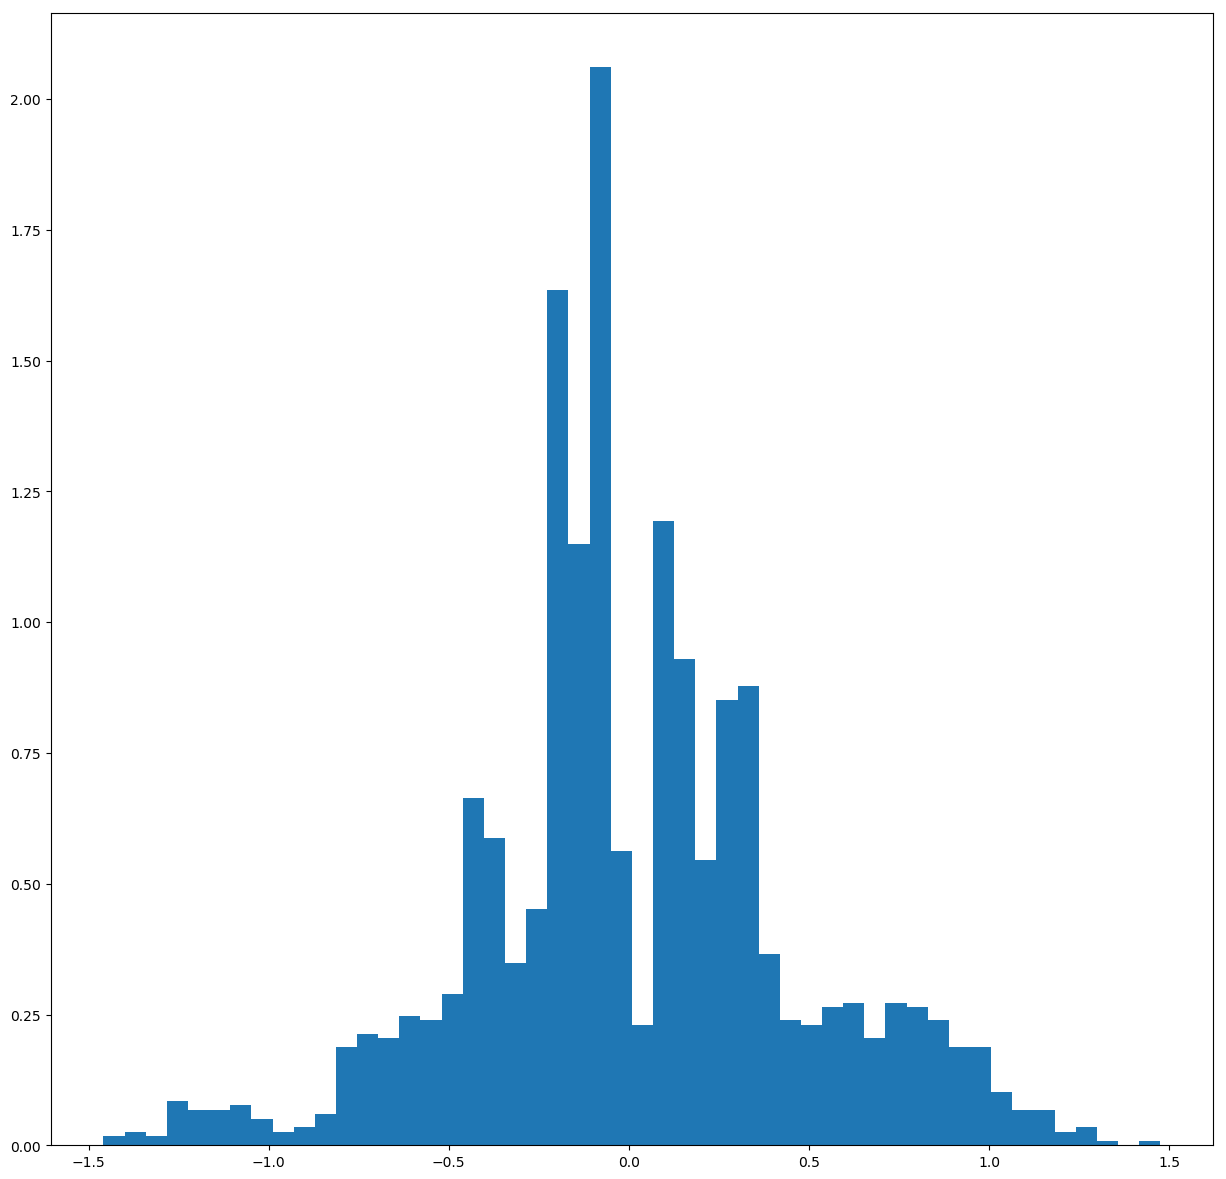

week


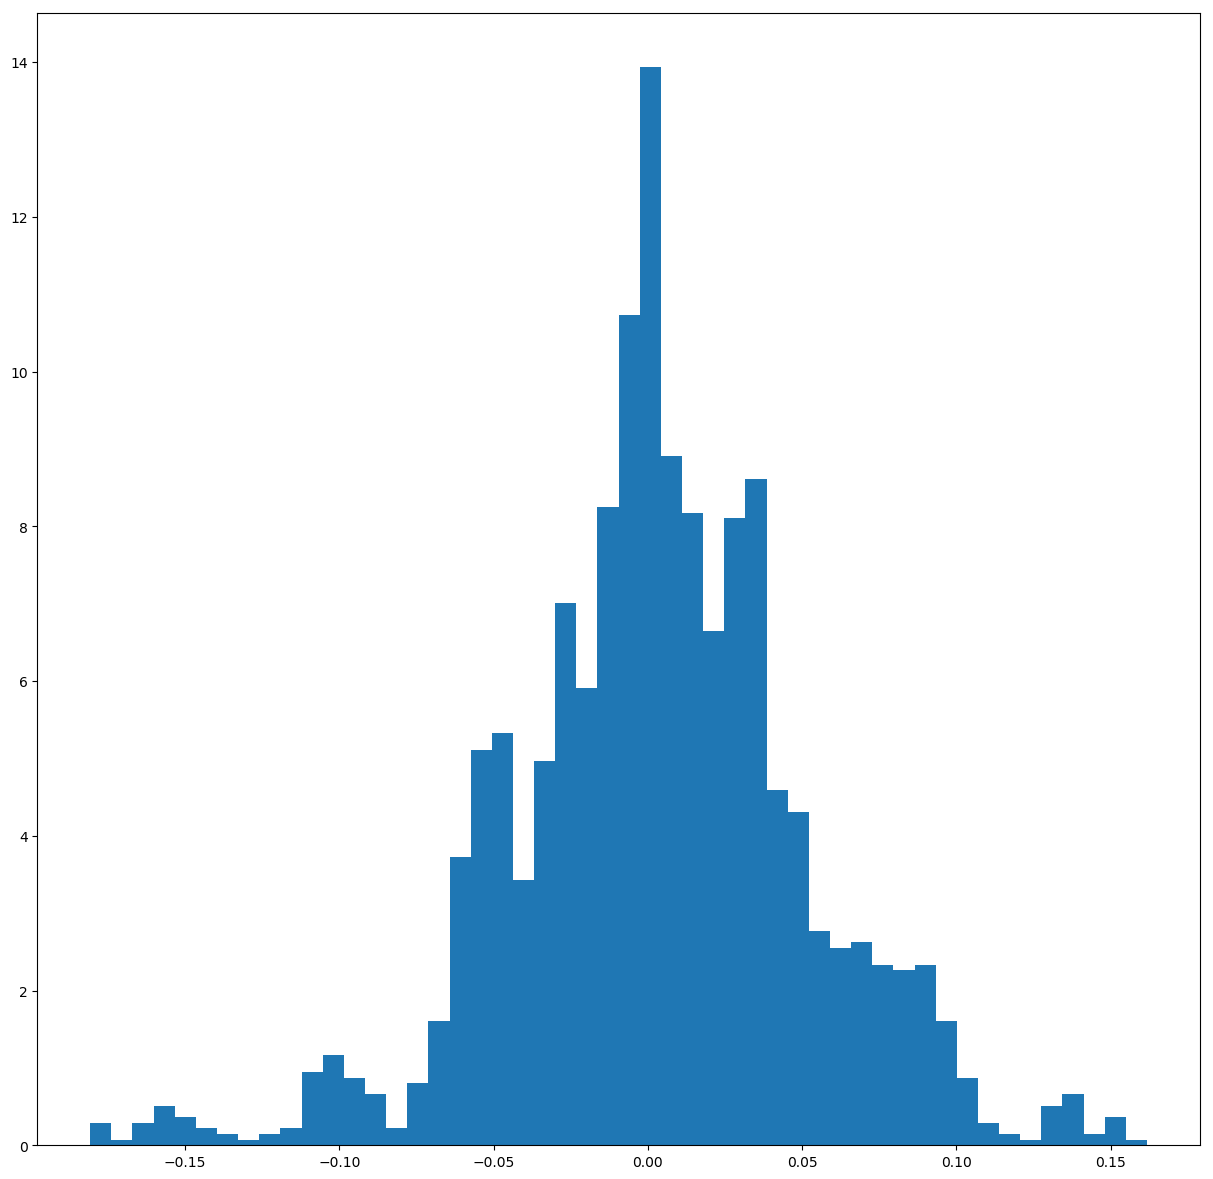

In [78]:
S1 = samples(model_sampled1N)
S_initial1 = W[:ind]

week, strong = 500, -5

print('distribution in strong pixel, train and initial model1 ')
plt.hist(S1[:, strong], bins=50, density=True, alpha=0.5)
plt.hist(S_initial1[:, strong], bins=50, density=True, alpha=0.5)
plt.show()


print('distribution in week pixel, train and initial model1 ')
plt.hist(S1[:, week], bins=50, density=True, alpha=0.5)
plt.hist(S_initial1[:, week], bins=50, density=True, alpha=0.5)
plt.show()

rcParams['figure.dpi'] = 100

print('strong')
plt.hist(S1[:, strong], bins=50, density=True)
plt.show()

print('week')
plt.hist(S1[:, week], bins=50, density=True)
plt.show()


In [79]:
W2N = noisify_good_weights(model2)
B = []
B.append(list(model2.parameters())[-1].data.numpy())
B = np.array(B)
model_sampled2N = get_model(W2N, B)
test(model_sampled2N)

{'nll': 0.17950828397870064, 'loss': 0.17950828397870064, 'accuracy': 99.535}
{'nll': 1.2993724159240723, 'loss': 1.2993724159240723, 'accuracy': 97.91}


In [80]:
train(model_sampled2N)

  ep    tr_loss     tr_acc     te_nll     te_acc       time
----  ---------  ---------  ---------  ---------  ---------
   0     0.1717    99.5650     1.2603    97.9700     4.0402
  ep    tr_loss     tr_acc     te_nll     te_acc       time
----  ---------  ---------  ---------  ---------  ---------
   1     0.1584    99.6133     1.2324    98.0400     4.0257
  ep    tr_loss     tr_acc     te_nll     te_acc       time
----  ---------  ---------  ---------  ---------  ---------
   2     0.1487    99.6400     1.2103    98.0600     4.0857
  ep    tr_loss     tr_acc     te_nll     te_acc       time
----  ---------  ---------  ---------  ---------  ---------
   3     0.1414    99.6650     1.1929    98.1200     3.9919
  ep    tr_loss     tr_acc     te_nll     te_acc       time
----  ---------  ---------  ---------  ---------  ---------
   4     0.1357    99.6867     1.1788    98.1500     3.9764
  ep    tr_loss     tr_acc     te_nll     te_acc       time
----  ---------  ---------  ---------  -

In [83]:
model_sampled2N.cpu();

In [84]:
 test_Arc_model(model_sampled1N, model_sampled2N)

(2000, 795)
computing Arc model...
test Arc
{'nll': 0.30610302562812963, 'loss': 0.30610302562812963, 'accuracy': 99.62666666666667}
{'nll': 2.6680839080810546, 'loss': 2.6680839080810546, 'accuracy': 98.04}


In [87]:
W1, ind1 = get_zero_W(model_sampled1N)
W2, ind2 = get_zero_W(model_sampled2N)

In [88]:
ind2, ind2

(2000, 2000)

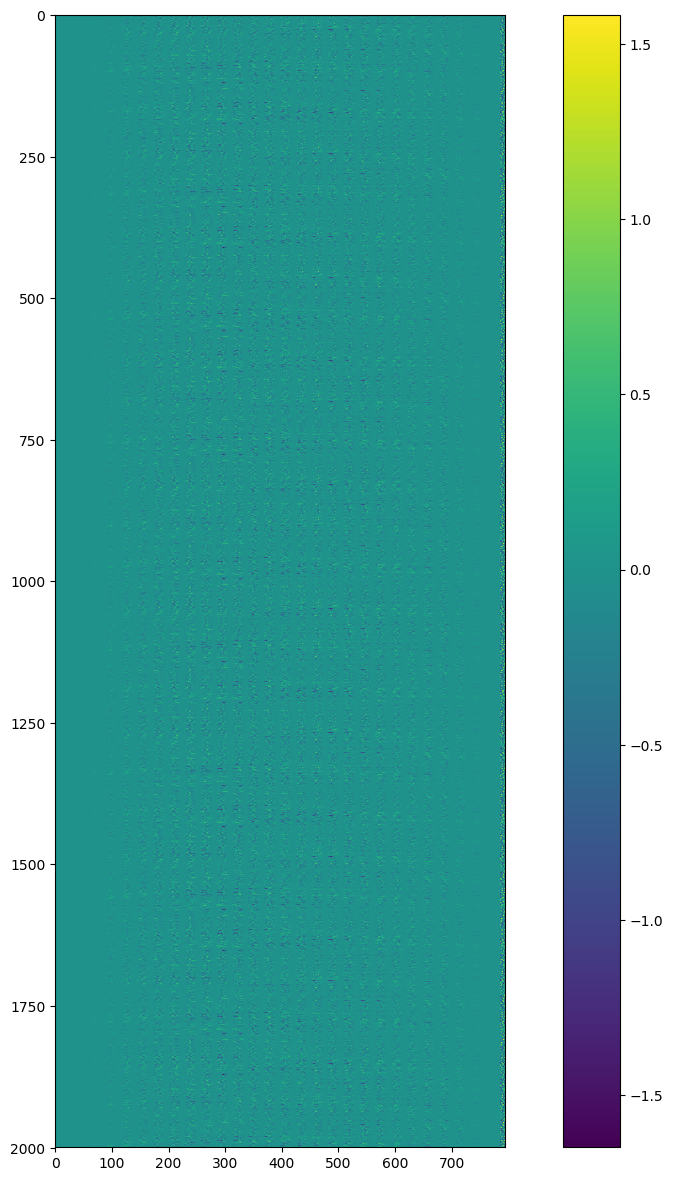

In [92]:
plt.imshow(W1)
plt.colorbar()

In [99]:
def train(model):
    
    criterion = F.cross_entropy
    regularizer = None 
    optimizer = torch.optim.Adam(
        filter(lambda param: param.requires_grad, model.parameters()),
        lr=0.001,
#         momentum=0.9,
        weight_decay=1e-4
    )
    model.cuda();

    columns = ['ep', 'tr_loss', 'tr_acc', 'te_nll', 'te_acc', 'time']
    for epoch in range(0, 10 + 1):
        time_ep = time.time()

        train_res = utils.train(loaders['train'], model, optimizer, criterion, regularizer, cuda=True)
        test_res = utils.test(loaders['test'], model, criterion, regularizer, cuda=True)

        time_ep = time.time() - time_ep
        values = [epoch, train_res['loss'], train_res['accuracy'], test_res['nll'],
                  test_res['accuracy'], time_ep]

        table = tabulate.tabulate([values], columns, tablefmt='simple', floatfmt='9.4f')
        print(table)

In [101]:
train(model_sampled2N)

  ep    tr_loss     tr_acc     te_nll     te_acc       time
----  ---------  ---------  ---------  ---------  ---------
   0     0.1931    99.2750     0.8992    97.7700     4.0392
  ep    tr_loss     tr_acc     te_nll     te_acc       time
----  ---------  ---------  ---------  ---------  ---------
   1     0.1032    99.4583     0.7527    97.8200     4.1551
  ep    tr_loss     tr_acc     te_nll     te_acc       time
----  ---------  ---------  ---------  ---------  ---------
   2     0.0732    99.5367     0.7984    97.7200     4.0962
  ep    tr_loss     tr_acc     te_nll     te_acc       time
----  ---------  ---------  ---------  ---------  ---------
   3     0.0723    99.4750     0.7309    97.6000     4.1319
  ep    tr_loss     tr_acc     te_nll     te_acc       time
----  ---------  ---------  ---------  ---------  ---------
   4     0.0532    99.5250     0.6259    97.7000     4.0163
  ep    tr_loss     tr_acc     te_nll     te_acc       time
----  ---------  ---------  ---------  -

In [104]:
model_sampled1N.cpu(), model_sampled2N.cpu()
W1, ind1 = get_zero_W(model_sampled1N)
W2, ind2 = get_zero_W(model_sampled2N)
ind1, ind2

(89, 1910)

## Predictions on eigenvectors

/home/anokhin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until


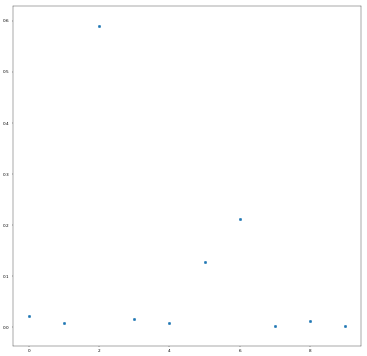

/home/anokhin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until


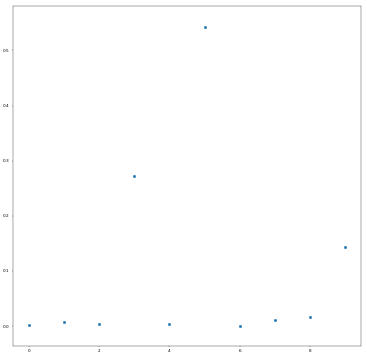

/home/anokhin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until


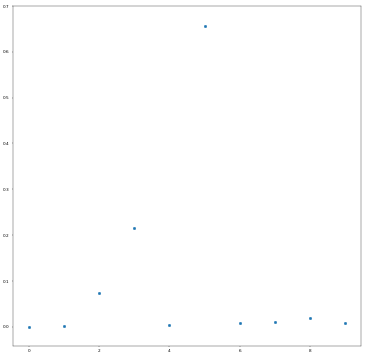

/home/anokhin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until


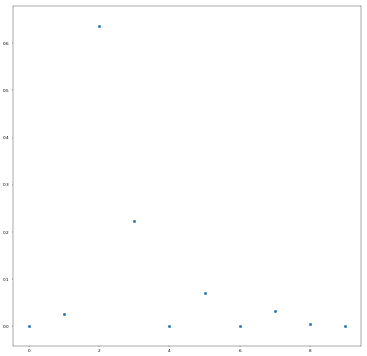

/home/anokhin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until


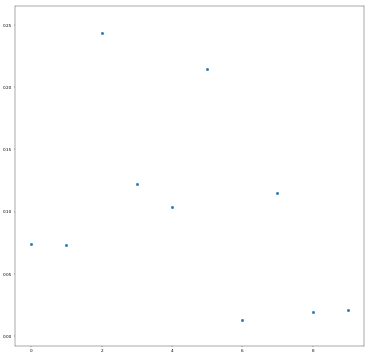

/home/anokhin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until


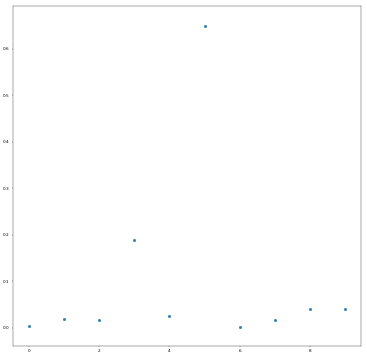

/home/anokhin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until


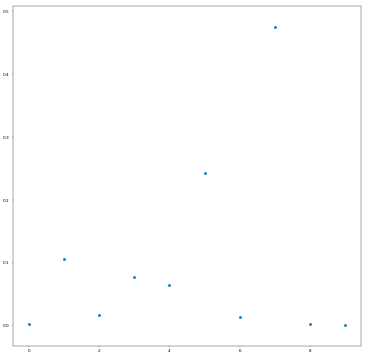

/home/anokhin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until


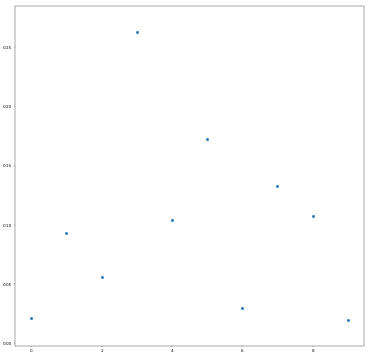

/home/anokhin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until


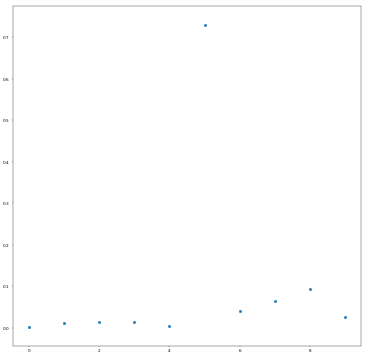

/home/anokhin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until


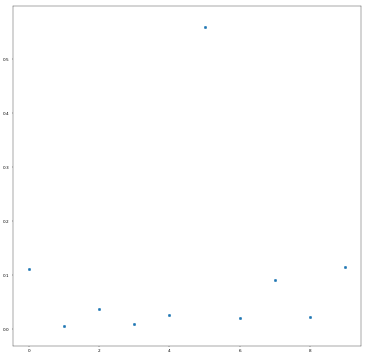

In [18]:
rcParams['figure.dpi'] = 30
for i in range(10):   
    plt.scatter(np.arange(10), F.softmax(model1(torch.tensor(vh[i:i+1]))).cpu().data)
    plt.show()

/home/anokhin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until


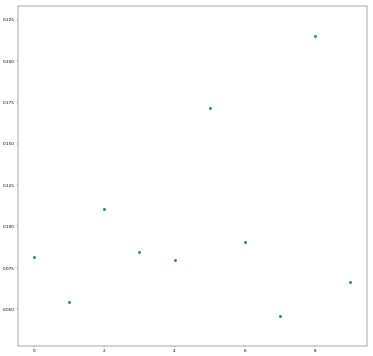

/home/anokhin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until


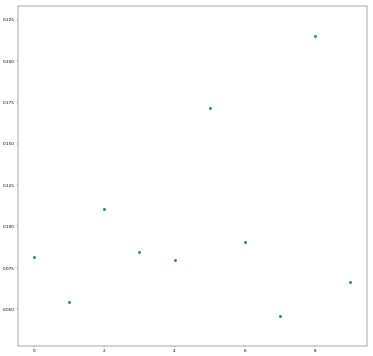

/home/anokhin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until


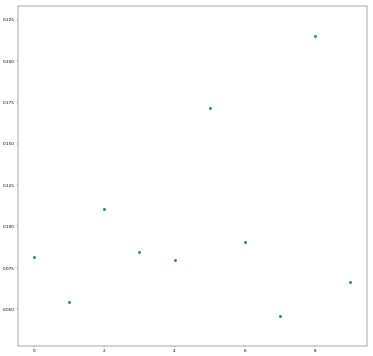

/home/anokhin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until


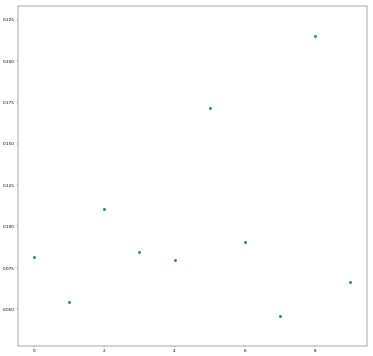

/home/anokhin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until


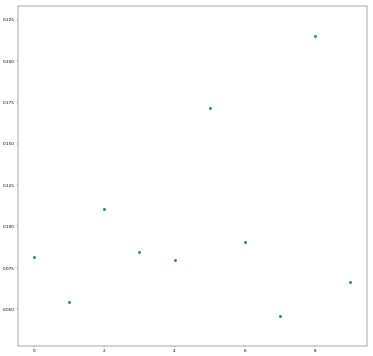

/home/anokhin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until


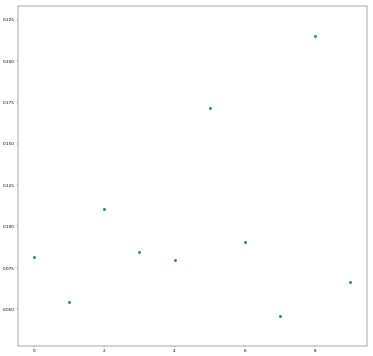

/home/anokhin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until


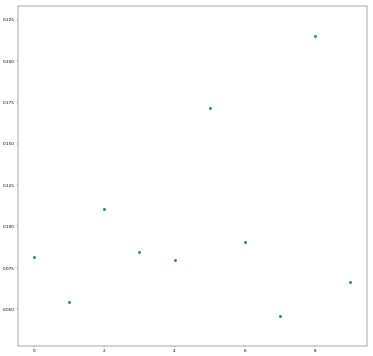

/home/anokhin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until


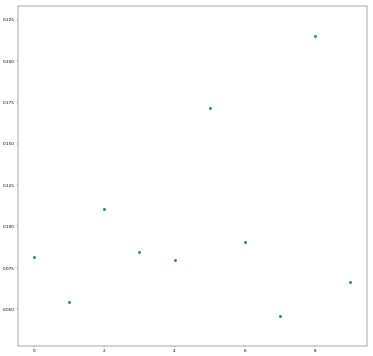

/home/anokhin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until


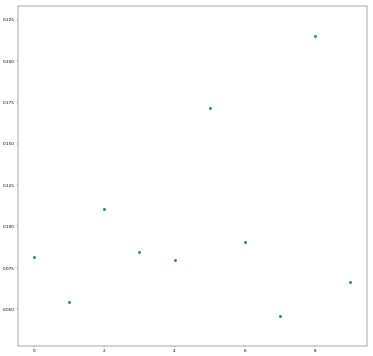

/home/anokhin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until


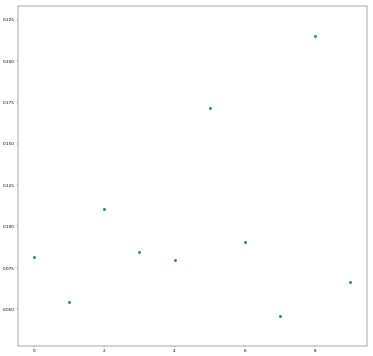

In [19]:
rcParams['figure.dpi'] = 30
for i in range(10):   
    plt.scatter(np.arange(10), F.softmax(model1(torch.tensor(vh[-i-2:-i-1]))).cpu().data)
    plt.show()